In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_dir = '/content/drive/MyDrive/chicken_disease_dataset_50050/train'
val_dir = '/content/drive/MyDrive/chicken_disease_dataset_50050/validation'

In [ ]:
total_train = 0

for i in os.listdir(train_dir):
  total_train += len(os.listdir(train_dir+'/'+i))
  print('Total File ', i, '=', len(os.listdir(train_dir+'/'+ i)))

print(total_train)

total_val = 0

for i in os.listdir(val_dir):
  total_val += len(os.listdir(val_dir+'/'+i))
  print('Total File ', i, '=', len(os.listdir(val_dir+'/'+ i)))

print(total_val)


total = 0
total = total_train + total_val
print('Total dataset = ', total)

Total File  New Castle Disease = 500
Total File  Coccidiosis = 500
Total File  Healthy = 504
Total File  Salmonella = 508
2012
Total File  Coccidiosis = 50
Total File  Healthy = 50
Total File  Salmonella = 50
Total File  New Castle Disease = 53
203
Total dataset =  2215


In [ ]:
def view_random_image (target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder),1)

  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f"Ukuran gambar : {img.shape}")
  return img

Ukuran gambar : (224, 224, 3)


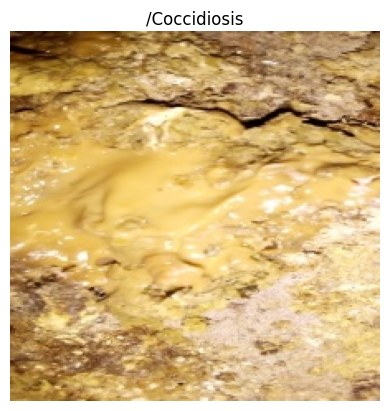

In [ ]:
img = view_random_image (train_dir, '/Coccidiosis')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
		rescale = 1./255,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50.0,
		shear_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=15
)

validation_generator = validation_datagen.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=15
)

Found 2012 images belonging to 4 classes.
Found 203 images belonging to 4 classes.


In [ ]:
# Mendapatkan pelabelan kelas dari generator pelatihan
train_class_indices = train_generator.class_indices
print("Pelabelan kelas dari generator pelatihan:")
print(train_class_indices)

# Mendapatkan pelabelan kelas dari generator validasi
val_class_indices = validation_generator.class_indices
print("\nPelabelan kelas dari generator validasi:")
print(val_class_indices)


Pelabelan kelas dari generator pelatihan:
{'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}

Pelabelan kelas dari generator validasi:
{'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}


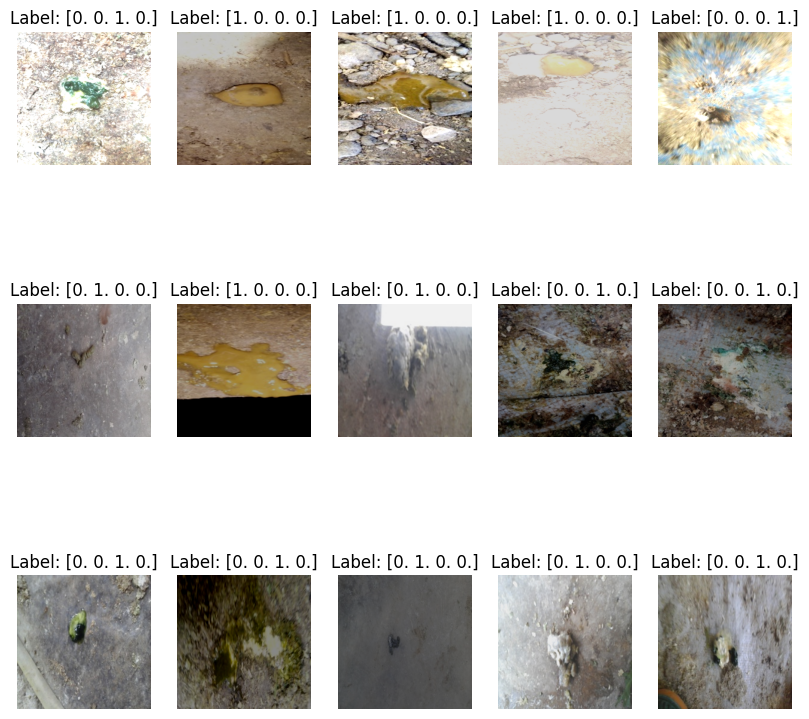

In [ ]:
import matplotlib.pyplot as plt

# Memuat satu batch gambar dari generator pelatihan
batch = next(train_generator)

# Mendapatkan array gambar yang telah di-augmentasi dan labelnya
images = batch[0]
labels = batch[1]

# Menampilkan gambar dan labelnya
plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title('Label: ' + str(labels[i]))
    plt.axis('off')

plt.show()


In [ ]:
# base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# for layer in base_model.layers:
#     layer.trainable = False

# model = tf.keras.models.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(4, activation='softmax')
# ])

# model.summary()

In [ ]:
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(150, 150, 3))

base_model.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Print the model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                           

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Setup learning rate reduction
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_schedule]
)

Epoch 1/50
135/135 [==============================] - 837s 6s/step - loss: 0.7529 - accuracy: 0.7202 - val_loss: 0.3295 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 2/50
135/135 [==============================] - 37s 277ms/step - loss: 0.4380 - accuracy: 0.8345 - val_loss: 0.2483 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 3/50
135/135 [==============================] - 36s 266ms/step - loss: 0.3809 - accuracy: 0.8574 - val_loss: 0.2377 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 4/50
135/135 [==============================] - 36s 268ms/step - loss: 0.3348 - accuracy: 0.8743 - val_loss: 0.2473 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 5/50
135/135 [==============================] - 38s 280ms/step - loss: 0.3142 - accuracy: 0.8887 - val_loss: 0.1822 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 6/50
135/135 [==============================] - 38s 278ms/step - loss: 0.2887 - accuracy: 0.8946 - val_loss: 0.1687 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 7/50
135/135 [==============================] - 

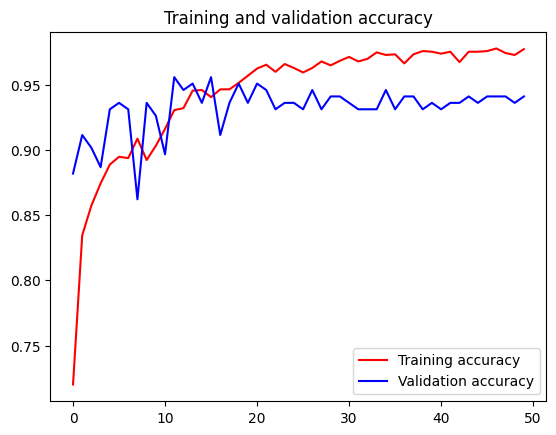

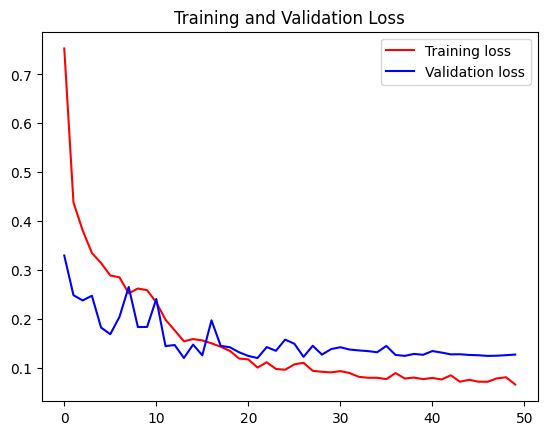

In [ ]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)


plt.show()

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# Daftar label yang sesuai dengan kelas dari generator
class_labels = ['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0

  images = np.vstack([x])
  arr = model.predict(images, batch_size=10)

  # Mengambil indeks kelas dengan nilai probabilitas tertinggi
  predicted_class_index = np.argmax(arr)

  # Menentukan label prediksi
  predicted_label = class_labels[predicted_class_index]

  # Menampilkan hasil prediksi
  print('{} is a {}'.format(fn, predicted_label))

Saving healthy.85.jpg to healthy.85 (1).jpg
1/1 [==============================] - 0s 21ms/step
healthy.85 (1).jpg is a Healthy


Found 689 images belonging to 4 classes.
22/22 [==============================] - 223s 11s/step
Confusion Matrix
[[211   3   5   1]
 [  1 211   5   3]
 [  0   2  27   0]
 [  1  15  13 191]]
Classification Report
                    precision    recall  f1-score   support

       Coccidiosis       0.99      0.96      0.97       220
           Healthy       0.91      0.96      0.94       220
New Castle Disease       0.54      0.93      0.68        29
        Salmonella       0.98      0.87      0.92       220

          accuracy                           0.93       689
         macro avg       0.86      0.93      0.88       689
      weighted avg       0.94      0.93      0.93       689



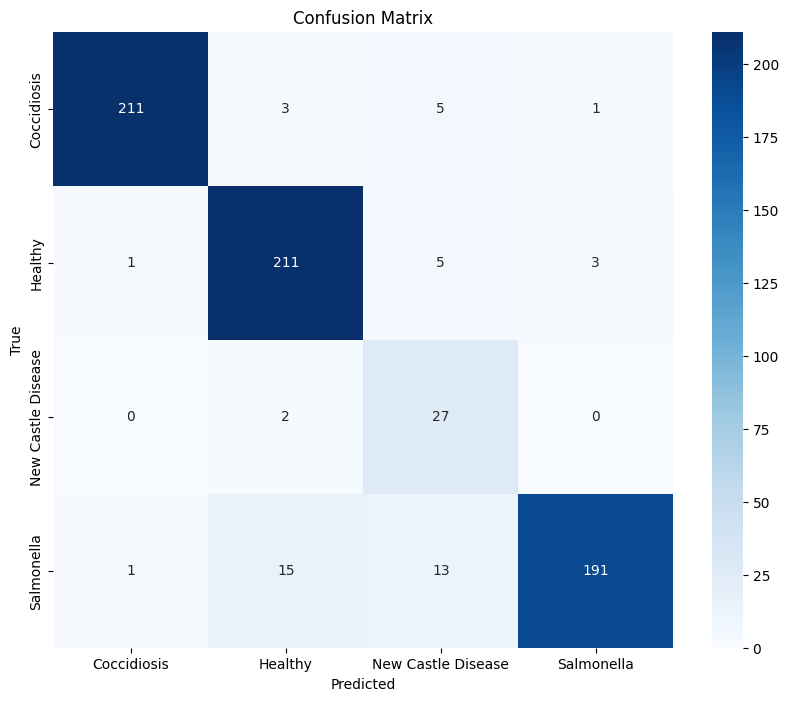

In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke folder test
test_dir = '/content/drive/MyDrive/chicken_disease_dataset_50050/test'

# Membuat ImageDataGenerator untuk test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

# Melakukan prediksi menggunakan model pada test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Mendapatkan label sebenarnya dari test data
true_classes = test_generator.classes

# Mendapatkan label nama kelas dari generator
class_labels = list(test_generator.class_indices.keys())

# Menghitung confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix")
print(cm)

# Menghitung classification report
cr = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report")
print(cr)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('mobilenet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pip install tensorflowjs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
     

In [ ]:
!tensorflowjs_converter --input_format keras mobilenet.h5 /content/tfjs_model


2024-05-28 09:22:10.919139: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 09:22:12.593892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from google.colab import files
import shutil

# Kompres folder tfjs_model menjadi zip
shutil.make_archive('tfjs_model', 'zip', '/content/tfjs_model')

# Unduh file zip
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>